In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"

import torch
import torch.nn as nn
import torch.nn.functional as F

from gpt2_model import * 
from SAE_model import *
from data_loader import *
from loss import *

from configs import *

# ----- 
run_name = 'trial1'

gpt_config = GPT_Config
model_name = gpt_config.model_name
sae_config = JL_SAE_Config
sae_model_name = sae_config.model_name
sae_layer = GPT_Config.n_layer // 2


### 1) Initialization

The first couple code blocks initialize the model and some run some tokens through them. Afterwards we run some analysis to see how the model's features behave (e.g. check gradient balance between loss functions, neuron activations, encoder matrix, etc.). 

In [2]:
#Load in models

#Load in base model
model = GPT.from_pretrained('gpt2')
model.to(device)

#Freeze params, eval mode
for name, param in model.named_parameters():
    param.requires_grad = False
model.eval()

#Load in SAE
sae_model = SAE(gpt_config, sae_config)
sae_model.to(device)

# Load in pretrained weights
weight_file = os.path.join(weights_dir, f"{model_name}_{sae_model_name}_layer{sae_layer}_{run_name}.ckpt")
if os.path.exists(weight_file):
    print(f'Loading in pretrained SAE weights from {weight_file}')
    sae_model.load_state_dict(torch.load(weight_file, map_location=device, weights_only=True))
sae_model.eval()


loading weights from pretrained gpt: gpt2
GPT2 model finished loading
Loading in pretrained SAE weights from /Users/alexxu/Desktop/Folder/ML/SAE/weights/gpt2-small_jl-sae_layer6_trial1.ckpt


SAE(
  (enc): Linear(in_features=768, out_features=8192, bias=False)
  (dec): Linear(in_features=8192, out_features=768, bias=False)
)

In [3]:
# Load in some tokens, either from sample text or from data loader

import tiktoken
import random

enc = tiktoken.get_encoding('gpt2')
input_text = None

# Get val loader
B = 1 #Batch size
T = 1024 #Sequence length
loader = DataLoader(B, T, val_shards)
loader.current_position = random.randint(0,100000000)

if input_text:
    toks = enc.encode(input_text)[:1024]
    x = torch.tensor(toks)
else:
    x = loader.next_batch()
    toks = x[0,:].tolist()

text = enc.decode(toks)
print(f"Number of tokens: {len(toks)}")
print(f"Text: {text[:500]}") #Just enough to get the jist

x = x.to(device)


Number of tokens: 1024
Text:  the matter of the sacrament was no necessary article of faith under pain of damnation. Next, that Christ had a natural body (apart from sin), and could not be in two places at once. Third, that 'This is my body' was not literal. Last, that what the church practised was not what Christ instituted." (46)
Thomas More obtained a copy of the essay. Catholics like More upheld the doctrine of transubstantiation, whereby the bread and wine became in actual fact the body and blood of Christ. It is belie


In [ ]:
# Forward pass through the model

with torch.autocast(device_type=device, dtype=torch.bfloat16):
    _, _, stream = model(x, get_stream=True)
    sae_data = stream[sae_layer]
    sae_in = sae_data[0].flatten(start_dim=0,end_dim=1)
    out, hidden_activation = sae_model(sae_in) 

reconstruction_error = out - sae_in

mse_loss = (reconstruction_error ** 2).mean()
l1_loss = normalized_L1_loss(sae_in, hidden_activation)
jl_loss = JL_loss(sae_model.dec.weight.T, input_dim=gpt_config.n_embd) 
print(f"MSE loss: {mse_loss.detach():.4f},L1_loss: {l1_loss.detach():.4f}, JL_loss: {jl_loss.detach():.4f}")




MSE loss: 0.0006,L1_loss: 61.1730, JL_loss: 0.5851
L2 loss:  tensor(446.4969, device='mps:0', grad_fn=<SumBackward0>)
L1 Loss:  tensor(372736., device='mps:0', dtype=torch.bfloat16, grad_fn=<SumBackward0>)


In [5]:
# Gradient size checking
optimizer = torch.optim.SGD(sae_model.parameters(), lr = 1e-4)

mse_loss = (reconstruction_error ** 2).mean()
mse_loss.backward(retain_graph=True)
with torch.no_grad():
    dot = torch.linalg.vecdot(sae_model.dec.weight.T,sae_model.dec.weight.grad.T)
    sae_model.dec.weight.grad -= (dot.unsqueeze(1) * sae_model.dec.weight.T).T
print(f"MSE gradients: Encoder: {sae_model.enc.weight.grad.norm()}, Decoder: {sae_model.dec.weight.grad.norm()}")
sae_model.enc.weight.grad, sae_model.dec.weight.grad = torch.zeros_like(sae_model.enc.weight.grad), torch.zeros_like(sae_model.dec.weight.grad)

l1_loss = normalized_L1_loss(sae_in, hidden_activation)
l1_loss.backward(retain_graph=True)
print(f"L1 gradients: Encoder: {sae_model.enc.weight.grad.norm()}, Decoder: {sae_model.dec.weight.grad.norm()}")
sae_model.enc.weight.grad, sae_model.dec.weight.grad = torch.zeros_like(sae_model.enc.weight.grad), torch.zeros_like(sae_model.dec.weight.grad)

jl_loss = JL_loss(sae_model.dec.weight.T, input_dim=gpt_config.n_embd) 
jl_loss.backward(retain_graph=True)
print(f"JL gradients: Encoder: {sae_model.enc.weight.grad.norm()}, Decoder: {sae_model.dec.weight.grad.norm()}")
sae_model.enc.weight.grad, sae_model.dec.weight.grad = torch.zeros_like(sae_model.enc.weight.grad), torch.zeros_like(sae_model.dec.weight.grad)


MSE gradients: Encoder: 0.001201147329993546, Decoder: 0.003128930926322937
L1 gradients: Encoder: 19.42299461364746, Decoder: 0.0
JL gradients: Encoder: 0.0, Decoder: 0.013263978995382786


In [14]:
# L1 loss checking
token = 1000
token_in = sae_in[token,:]
token_activations = hidden_activation[token,:]

normalized_activations = token_activations / torch.linalg.vector_norm(token_in)
topk_activations, _ = torch.topk(normalized_activations,k=30)
large_activations = (token_activations > 0.5).sum().detach().to('cpu')
significant_activations = (token_activations > 0.1).sum().detach().to('cpu')

print(f"Large activations: {large_activations}, Significant activations: {significant_activations}")
print(f"Normalized activations: {topk_activations}")

print("Token L2 loss: ", (reconstruction_error[token,:] ** 2).sum())
print("Token L1 Loss: ", (token_activations).sum())


Large activations: 48, Significant activations: 1180
Normalized activations: tensor([0.2617, 0.1377, 0.1367, 0.1357, 0.1338, 0.1270, 0.1172, 0.1172, 0.1167,
        0.1147, 0.1147, 0.1143, 0.1113, 0.1074, 0.1069, 0.1021, 0.1021, 0.1021,
        0.1016, 0.1006, 0.0986, 0.0981, 0.0967, 0.0962, 0.0962, 0.0962, 0.0957,
        0.0957, 0.0942, 0.0923], device='mps:0', dtype=torch.bfloat16,
       grad_fn=<TopkBackward0>)
Token L2 loss:  tensor(0.4445, device='mps:0', grad_fn=<SumBackward0>)
Token L1 Loss:  tensor(326., device='mps:0', dtype=torch.bfloat16, grad_fn=<SumBackward0>)


tensor([0.3909, 0.3765, 0.3695, 0.3679, 0.3615, 0.3591, 0.3587, 0.3575, 0.3560,
        0.3536, 0.3507, 0.3477, 0.3450, 0.3433, 0.3408, 0.3399, 0.3383, 0.3358,
        0.3337, 0.3330, 0.3302, 0.3301, 0.3274, 0.3273, 0.3272, 0.3271, 0.3239,
        0.3235, 0.3224, 0.3216, 0.3215, 0.3201, 0.3199, 0.3171, 0.3169, 0.3147,
        0.3144, 0.3129, 0.3128, 0.3126, 0.3115, 0.3114, 0.3107, 0.3096, 0.3096,
        0.3085, 0.3077, 0.3058, 0.3053, 0.3043, 0.3011, 0.3007, 0.3003, 0.2999,
        0.2995, 0.2994, 0.2994, 0.2991, 0.2991, 0.2986, 0.2982, 0.2981, 0.2976,
        0.2975, 0.2974, 0.2972, 0.2959, 0.2958, 0.2956, 0.2949, 0.2947, 0.2947,
        0.2946, 0.2946, 0.2946, 0.2942, 0.2934, 0.2921, 0.2916, 0.2914, 0.2914,
        0.2912, 0.2910, 0.2905, 0.2896, 0.2894, 0.2889, 0.2886, 0.2885, 0.2884,
        0.2884, 0.2879, 0.2877, 0.2870, 0.2868, 0.2866, 0.2863, 0.2860, 0.2859,
        0.2859])
[(1860, 1809), (1754, 361), (4013, 2324), (2027, 7765), (5529, 3503), (1109, 1090), (3285, 2966), (5986

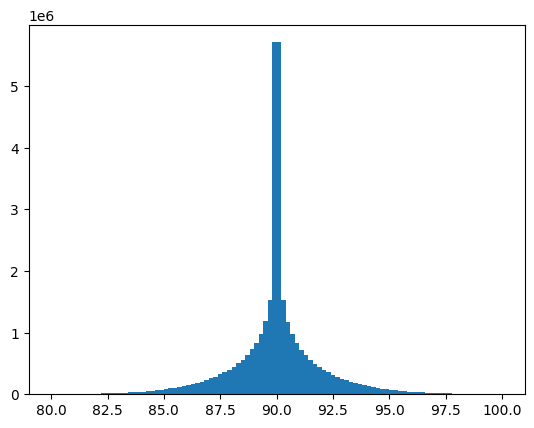

In [15]:
# Johnson Lindenstrauss loss checking 
import matplotlib.pyplot as plt
hidden_dim = sae_config.h_dim
A = sae_model.dec.weight.T

k = torch.arange(hidden_dim * (hidden_dim - 1) // 2)
pairwise_dots = (A @ A.T) [(k // hidden_dim + k % hidden_dim + 1) % hidden_dim, k % hidden_dim].detach().to('cpu')
pairwise_angles = torch.acos(pairwise_dots) * 180 / 3.1415926

highest_dots, ids = torch.topk(pairwise_dots, k=100)
print(highest_dots)

# vectors that have relatively high dot products good candidates for interesting features
def get_ij(id):
    return int((id // hidden_dim + id % hidden_dim + 1) % hidden_dim), int(id % hidden_dim)
pairs = [get_ij(id) for id in ids]
print(pairs)

eps = 10
plt.hist(pairwise_angles, bins=100, range=(90 - eps,90 + eps))
plt.show()


### 2 Neuron visualization

The following functions are to find candidate features (neurons) and see how they light up on sample batches of text. 

In [8]:
# Gets topk activations for the last token in the sequence
# Use for finding candidate tokens

def get_top_sae_activations(toks, k=10):
    _, _, stream = model(toks, get_stream=True)
    sae_data = stream[sae_layer]
    sae_in = sae_data[0].flatten(start_dim=0,end_dim=1)
    _, hidden_activation = sae_model(sae_in) 
    activations = hidden_activation[-1].to('cpu')
    act_values, positions = torch.topk(activations, k)
    return act_values, positions

text = "Back in my university days, my favorite subject was"
toks = torch.tensor(enc.encode(text),device=device)
toks = toks.view(1,len(toks))

act_values, positions = get_top_sae_activations(toks)
print("Top activation values: ", act_values)
print("Positions:" , positions)


Top activation values:  tensor([1.2240, 0.8245, 0.7856, 0.6994, 0.6867, 0.6704, 0.6663, 0.6418, 0.6096,
        0.6014], grad_fn=<TopkBackward0>)
Positions: tensor([4247, 2257, 7353, 4419, 6562, 3466, 4793, 4164, 1062, 7122])


['Back', ' in', ' my', ' university', ' days', ',', ' my', ' favorite', ' subject', ' was', ' mathematics', '.', ' I', ' loved', ' it', ' because', ' it', ' was', ' intellectually', ' stimulating', '.']


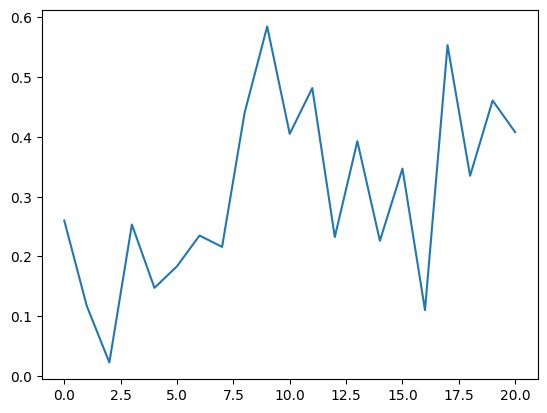

['The', ' most', ' meaningful', ' subject', ' that', ' you', ' can', ' study', ' is', ' artificial', ' intelligence']


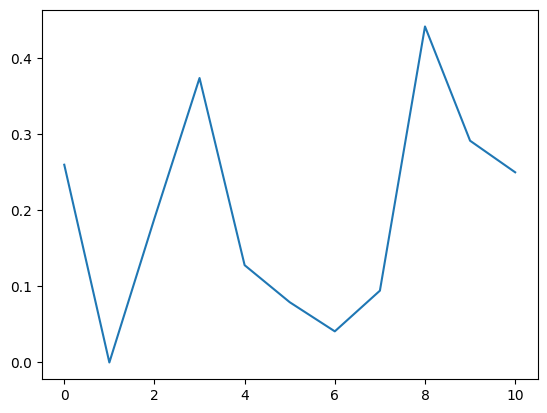

In [19]:
# Gets stream of activations for a specific given neuron
# Use for plotting graphs

def plot_sae_neuron_activations(text, neuron_num):
    toks = torch.tensor(enc.encode(text),device=device)
    toks = toks.view(1,len(toks))

    _, _, stream = model(toks, get_stream=True)
    sae_data = stream[sae_layer]
    sae_in = sae_data[0].flatten(start_dim=0,end_dim=1)
    _, hidden_activation = sae_model(sae_in) 

    activations = hidden_activation[:,neuron_num].to('cpu').detach()
    return activations

text = "Back in my university days, my favorite subject was mathematics. I loved it because it was intellectually stimulating."
activations = plot_sae_neuron_activations(text, 4165)
print([enc.decode([tok]) for tok in enc.encode(text)])
plt.plot(torch.arange(len(activations)), activations)
plt.show()

text2 = "The most meaningful subject that you can study is artificial intelligence"
activations2 = plot_sae_neuron_activations(text2, 4165)
print([enc.decode([tok]) for tok in enc.encode(text2)])
plt.plot(torch.arange(len(activations2)), activations2)
plt.show()



In [10]:

def generate_text(toks, num_samples):
    return NotImplementedError


In [11]:

def generate_text_with_steering(toks, neuron, num_samples):
    return NotImplementedError
